### Загрузка необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Постановка задачи

В крупном магазине продуктовой сети появилась необходимость автоматического прогнозирования продаж товаров с целью более эффективного управления складскими запасами. Для этого нами были получены тестовые данные на 1 товар одного магазина сети за 2014 - 2018 гг. По информации от руководства сети, на продажи предоставленного товара не влияют продажи других товаров в магазине. Также известно, что товар все это время был в наличии в магазине.

### Загрузка данных

In [3]:
df=pd.read_csv('data_for_regression.csv', sep=';')
df.head()

,date,price,T,sales
0,2014-01-01,126.9,-27,87.110569
1,2014-01-02,126.9,-25,117.233120
2,2014-01-03,126.9,-20,109.978085
3,2014-01-04,126.9,-21,114.134202
4,2014-01-05,115.9,-24,125.839838


In [9]:
df.columns

Index(['date', 'price', 'T', 'sales'], dtype='object')

In [5]:
# Преобразуем поле date в тип дата
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')

### Данные

In [6]:
# Объем данных
df.shape

(1826, 4)

In [7]:
# Статистика
df.describe()

,price,T,sales
count,1826.000000,1826.000000,1826.000000
mean,109.736254,0.841731,207.388282
std,24.062636,16.843083,95.151028
min,69.900000,-34.000000,56.443239
25%,87.900000,-15.000000,138.657888
50%,105.900000,1.000000,185.898634
75%,124.900000,16.000000,253.047532
max,157.900000,32.000000,860.714197


Text(0, 0.5, 'Продажи, шт')

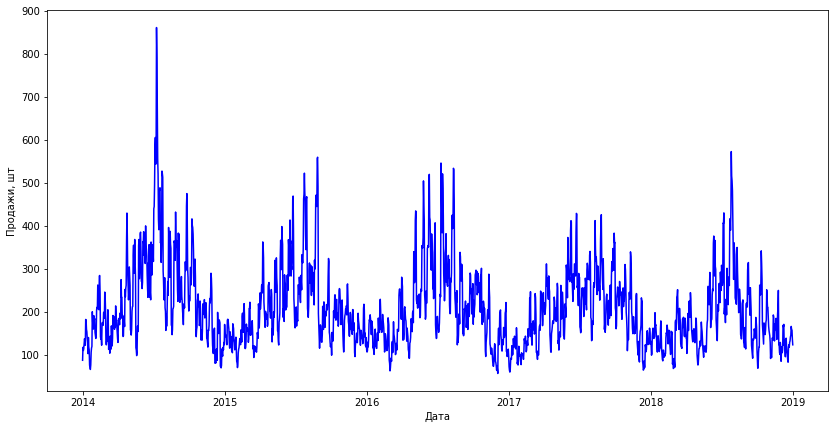

In [8]:
# График продаж за 2014 - 2018 гг.
plt.figure(figsize=(14,7))
plt.plot(df['date'], df['sales'], 'b')
plt.xlabel('Дата')
plt.ylabel('Продажи, шт')

Text(0, 0.5, 'Продажи, шт')

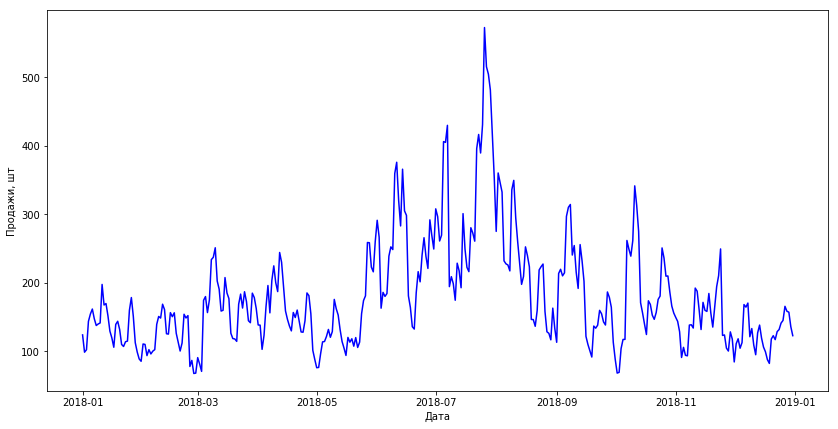

In [9]:
# График продаж за 2018 г.
plt.figure(figsize=(14,7))
plt.plot(df[df['date']>='2018-01-01']['date'], df[df['date']>='2018-01-01']['sales'], 'b')
plt.xlabel('Дата')
plt.ylabel('Продажи, шт')

### Генерация признаков даты

In [6]:
df['dw']=pd.DatetimeIndex(df.date).weekday+1
df['month']=pd.DatetimeIndex(df.date).month
df['year']=pd.DatetimeIndex(df.date).year

### Целевая переменная

(array([183., 533., 425., 319., 165.,  94.,  53.,  24.,  18.,   8.,   1.,
          1.,   0.,   1.,   1.]),
 array([ 56.44323912, 110.06130298, 163.67936684, 217.2974307 ,
        270.91549456, 324.53355842, 378.15162228, 431.76968614,
        485.38775   , 539.00581386, 592.62387772, 646.24194158,
        699.86000544, 753.4780693 , 807.09613316, 860.71419702]),
 <a list of 15 Patch objects>)

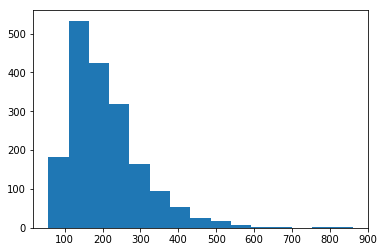

In [122]:
plt.hist(df['sales'], bins=15)

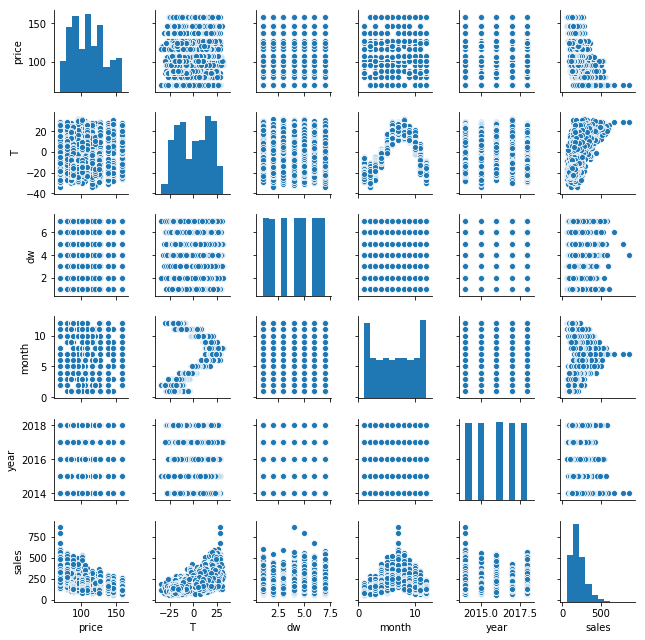

In [12]:
# Матрица графиков рассеяния геопризнаков и категории продаж
col=['price', 'T', 'dw', 'month', 'year', 'sales']
sns.pairplot(df[col], size=1.5)

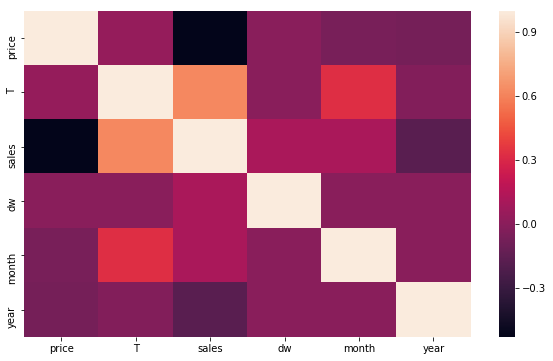

In [7]:
# Корреляционная матрица
data_corr=df.corr()

plt.figure(figsize = (10,6))
sns.heatmap(data_corr)

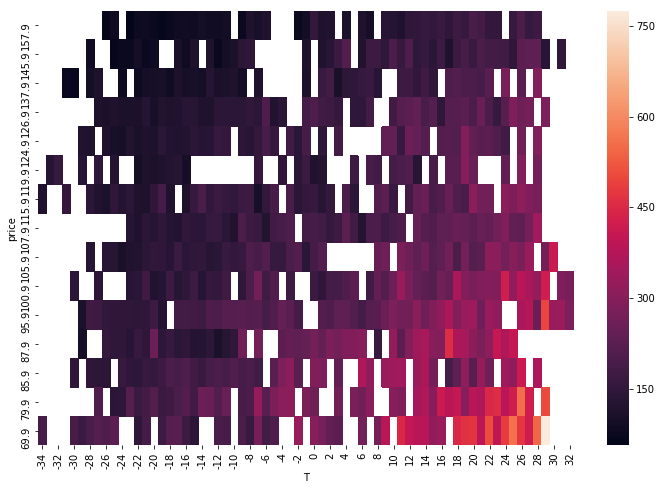

In [5]:
# Зависимость от долготы и широты
df_copy=df.copy()
# df_copy['longitude_round']=np.round(df_copy['longitude'], 0)
# df_copy['latitude_round']=np.round(df_copy['latitude'], 0)

plt.figure(figsize = (12,8))
sns.heatmap(df_copy.pivot_table('sales', index=['price'], 
                            columns=['T'],  aggfunc='mean').copy()
                                    .sort_values(by='price', ascending=False))

### Подготовка данных для обучения модели

In [8]:
# Разделение признаков и целевой переменной. Удаление неинформативных признаков.

X=df[[
    'price', 
    'T', 
    'dw', 
    'month', 
    'year'
    ]]

Y=df['sales']

### Разделение данных на обучающую и тестовую выборку

In [9]:
x_lim=int(len(X)*0.80)

X_train=X[0:x_lim].copy()
Y_train=Y[0:x_lim].copy()
X_test=X[x_lim+1:].copy()
Y_test=Y[x_lim+1:].copy()

### Типы данных

In [10]:
# Группировка по дням недели
df.groupby(by='dw').mean()[['sales']]

,sales
dw,
1,199.066736
2,179.044581
3,177.761544
4,237.697880
5,232.804503
6,221.693851
7,203.540286


In [11]:
# Разделение данных на вещественные и категориальные

X_train_v=X_train[['price', 'T', 'year']]
X_train_k=X_train[['dw', 'month']]

X_test_v=X_test[['price', 'T', 'year']]
X_test_k=X_test[['dw', 'month']]

In [12]:
# Обработка вещественных данных

from sklearn.preprocessing import StandardScaler

ss=StandardScaler()

X_train_v=ss.fit_transform(X_train_v)
X_test_v=ss.transform(X_test_v)

print('Минимум и максимум обучающего набора: ', X_train_v.min(), X_train_v.max())
print('Минимум и максимум тестового набора: ', X_test_v.min(), X_test_v.max())

Минимум и максимум обучающего набора:  -2.0773119583706046 1.997624828871071
Минимум и максимум тестового набора:  -1.7827779627969456 2.2379076059289975


In [13]:
# Обработка категориальных данных

from sklearn.preprocessing import OneHotEncoder

one=OneHotEncoder(sparse=False)
one.fit(X_train_k)
X_train_k=one.transform(X_train_k)
X_test_k=one.transform(X_test_k)

In [14]:
# Объединяем вещественные и категориальные данные

X_train_all=np.hstack((X_train_v, X_train_k))
X_test_all=np.hstack((X_test_v, X_test_k))

In [15]:
X_train_all.shape

(1460, 22)

### Базовое решение

В качестве базового решения используем методику ручного прогнозирования, используемого в сети: средние продажи за последние 30 дней.

In [16]:
Y_mean=Y_test.rolling(window=30).mean()

In [17]:
from sklearn.metrics import mean_absolute_error

print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Y_mean[30:]), 2))
print('Среднее значение продаж: ', np.round(Y_test[30:].mean(), 2))

Среднее абсолютное отклонение:  49.28
Среднее значение продаж:  184.07


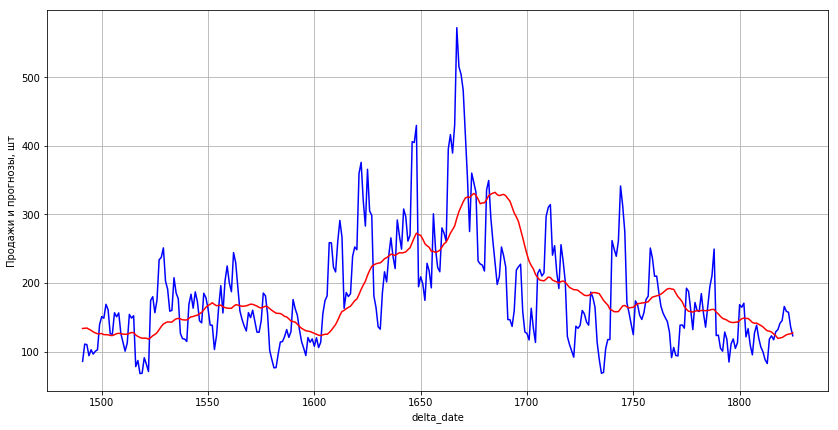

In [25]:
plt.figure(figsize=(14,7))
plt.plot(Y_test[30:], 'b')
plt.plot(Y_mean[30:], 'r')
plt.xlabel('delta_date')
plt.ylabel('Продажи и прогнозы, шт')
plt.grid()

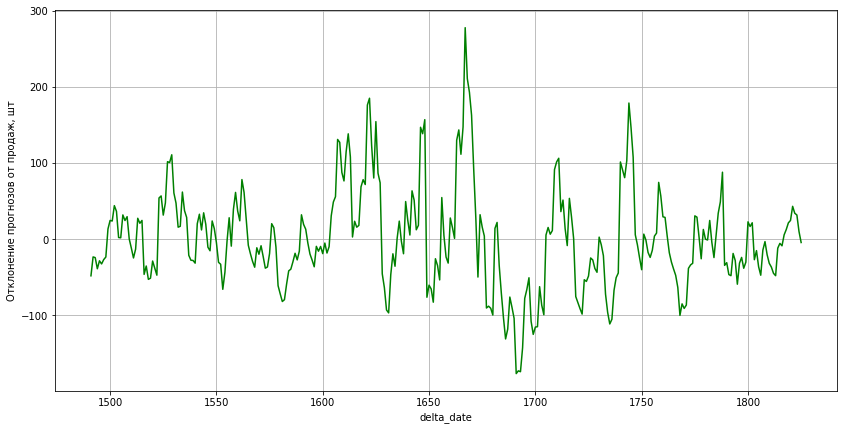

In [26]:
plt.figure(figsize=(14,7))
plt.plot(Y_test[30:] - Y_mean[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

### Линейная регрессия

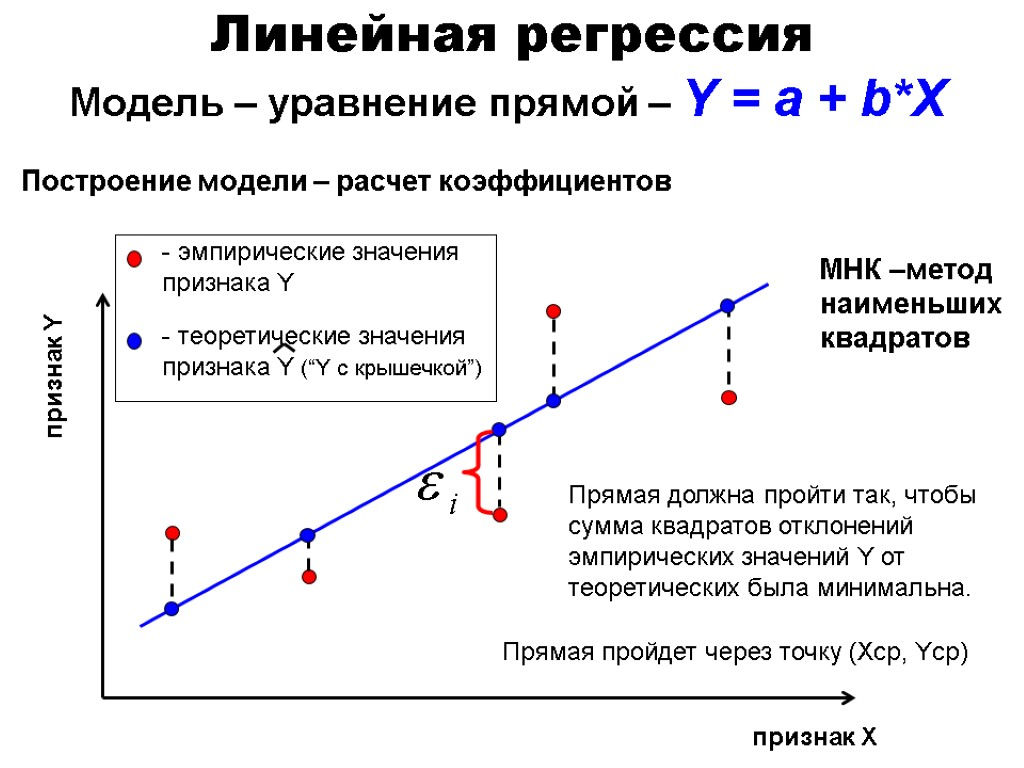

In [27]:
Image("linear_regression.jpg", width=500, height=500)

In [28]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
lr.fit(X_train_all, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
Pred_lr_train=lr.predict(X_train_all)
Pred_lr_test=lr.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_test[30:]), 2))

Среднее абсолютное отклонение:  28.18
Среднее абсолютное отклонение:  24.94


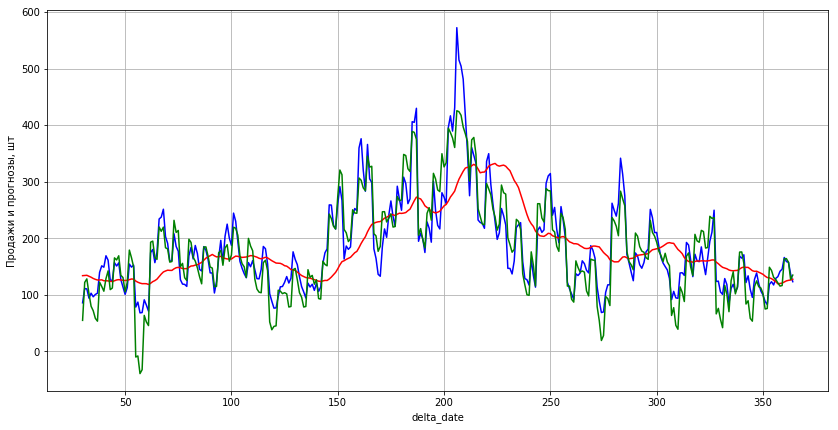

In [30]:
plt.figure(figsize=(14,7))
x=range(len(Y_test))
plt.plot(x[30:], Y_test[30:], 'b')
plt.plot(x[30:], Y_mean[30:], 'r')
plt.plot(x[30:], Pred_lr_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Продажи и прогнозы, шт')
plt.grid()

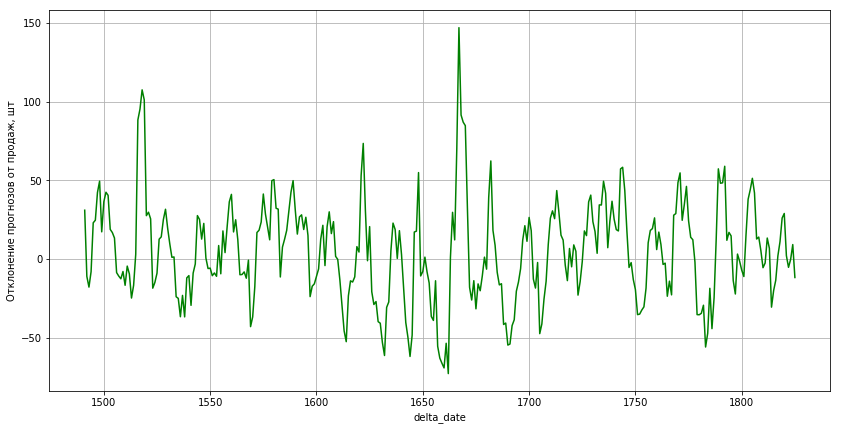

In [31]:
plt.figure(figsize=(14,7))
plt.plot(Y_test[30:] - Pred_lr_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

### Регуляризация

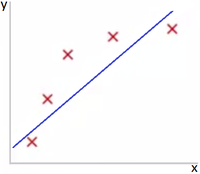

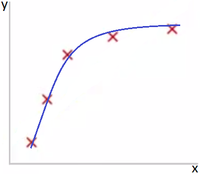

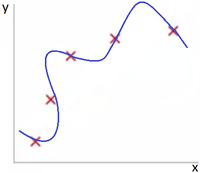

In [32]:
from IPython.display import display

i1=Image("reg1.png", width=250, height=250)
i2=Image("reg2.png", width=250, height=250)
i3=Image("reg3.png", width=250, height=250)

display(i1, i2, i3)

In [33]:
# Гребневая регрессия (L2 - регуляризация)

from sklearn.linear_model  import Ridge

lr_ridge=Ridge(alpha=10)
lr_ridge.fit(X_train_all, Y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [34]:
Pred_lr_ridge_train=lr_ridge.predict(X_train_all)
Pred_lr_ridge_test=lr_ridge.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_ridge_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_ridge_test[30:]), 2))

Среднее абсолютное отклонение:  28.33
Среднее абсолютное отклонение:  24.65


In [35]:
# Лассо регрессия (L1 - регуляризация)

from sklearn.linear_model  import Lasso

lr_lasso=Lasso(alpha=0.15)
lr_lasso.fit(X_train_all, Y_train)

Lasso(alpha=0.15, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
Pred_lr_lasso_train=lr_lasso.predict(X_train_all)
Pred_lr_lasso_test=lr_lasso.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_lasso_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_lasso_test[30:]), 2))

Среднее абсолютное отклонение:  28.25
Среднее абсолютное отклонение:  24.73


In [37]:
# Эластичная регрессия (L1 и L2 - регуляризация)

from sklearn.linear_model  import ElasticNet

lr_elastic=ElasticNet(alpha=0.05, l1_ratio=0.005)
lr_elastic.fit(X_train_all, Y_train)

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.005,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
Pred_lr_elastic_train=lr_elastic.predict(X_train_all)
Pred_lr_elastic_test=lr_elastic.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_elastic_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_elastic_test[30:]), 2))

Среднее абсолютное отклонение:  29.08
Среднее абсолютное отклонение:  23.7


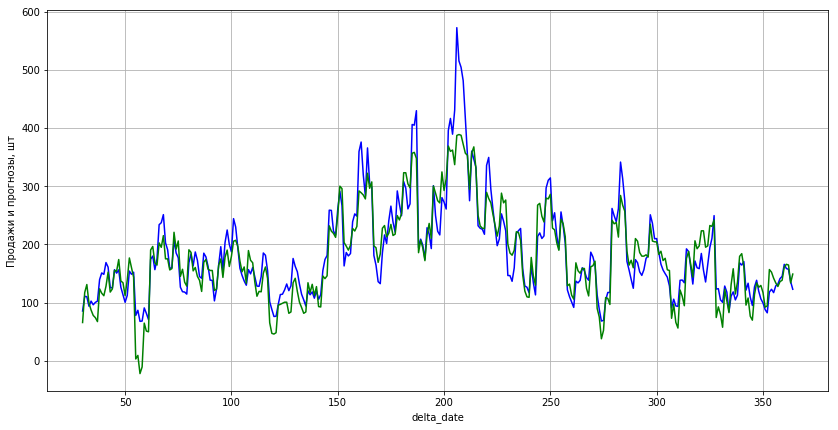

In [39]:
plt.figure(figsize=(14,7))
x=range(len(Y_test))
plt.plot(x[30:], Y_test[30:], 'b')
plt.plot(x[30:], Pred_lr_elastic_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Продажи и прогнозы, шт')
plt.grid()

## Статистические методы прогнозирования временных рядов

In [18]:
from scipy import stats
import statsmodels.api as sm

#### Индексация данных времеными метками

In [19]:
df=pd.read_csv('data_for_regression.csv', sep=';', index_col='date')
df.head()

,price,T,sales
date,,,
2014-01-01,126.9,-27,87.110569
2014-01-02,126.9,-25,117.233120
2014-01-03,126.9,-20,109.978085
2014-01-04,126.9,-21,114.134202
2014-01-05,115.9,-24,125.839838


In [20]:
x_lim=int(len(X)*0.80)

Train=df[0:x_lim].copy()
Test=df[x_lim+1:].copy()

#### Проверка стационарности временного ряда

Критерий Дики-Фуллера: p=0.000874


<Figure size 1008x504 with 0 Axes>

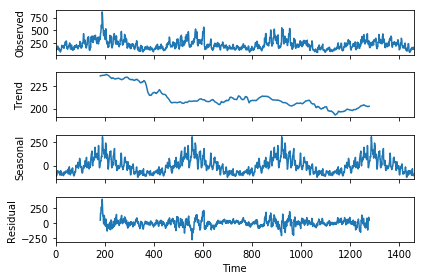

In [21]:
plt.figure(figsize=(14,7))
sm.tsa.seasonal_decompose(np.array(Train.sales), freq=365).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales)[1])

Критерий Дики-Фуллера: p=0.000874


<Figure size 1008x504 with 0 Axes>

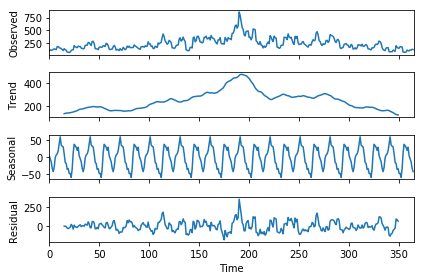

In [23]:
plt.figure(figsize=(14,7))
sm.tsa.seasonal_decompose(np.array(Train.sales[:365]), freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales)[1])

#### Преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: -0.020020
Критерий Дики-Фуллера: p=0.004674


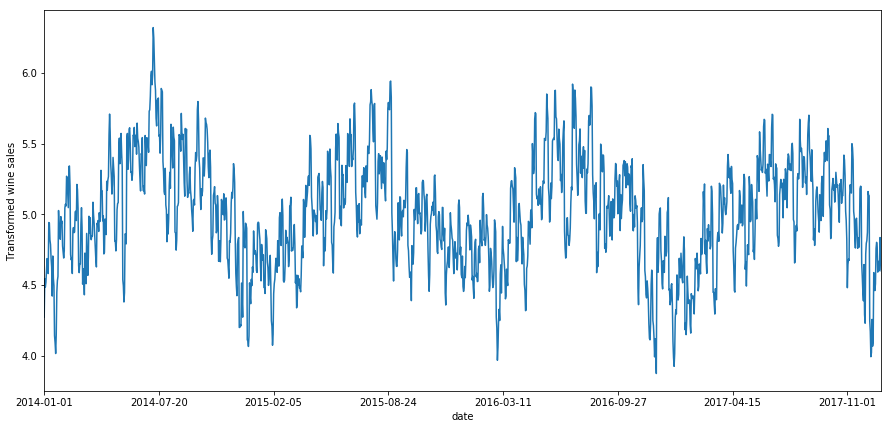

In [22]:
Train['sales_box'], lmbda = stats.boxcox(Train.sales)
plt.figure(figsize=(15,7))
Train.sales_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales_box)[1])

#### Стационарность

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x504 with 0 Axes>

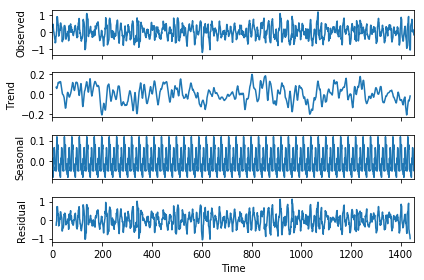

In [23]:
Train['sales_box_diff'] = Train.sales_box - Train.sales_box.shift(7)
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(np.array(Train.sales_box_diff[7:]), freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales_box_diff[7:])[1])

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

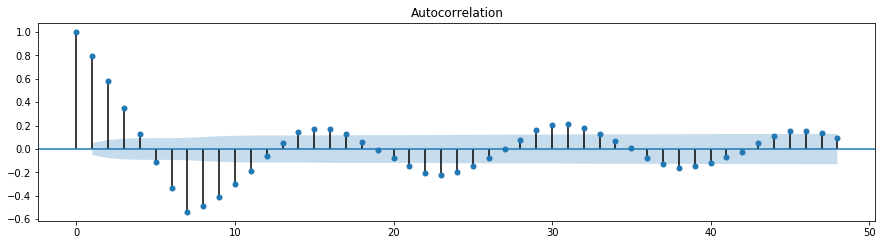

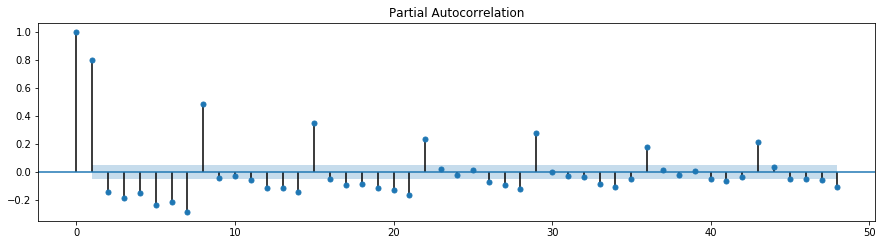

In [26]:
plt.figure(figsize=(15,8))
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(Train.sales_box_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(Train.sales_box_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [27]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [28]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [29]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(Train.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

KeyboardInterrupt: 

In [30]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

NameError: name 'results' is not defined

In [52]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                 1460
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood                 419.113
Date:                            Fri, 15 Feb 2019   AIC                           -824.225
Time:                                    16:15:28   BIC                           -787.285
Sample:                                01-01-2014   HQIC                          -810.439
                                     - 12-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4366      0.149      9.666      0.000       1.145       1.728
ar.L2         -0.5642      0.112   

Критерий Стьюдента: p=0.158344
Критерий Дики-Фуллера: p=0.000000


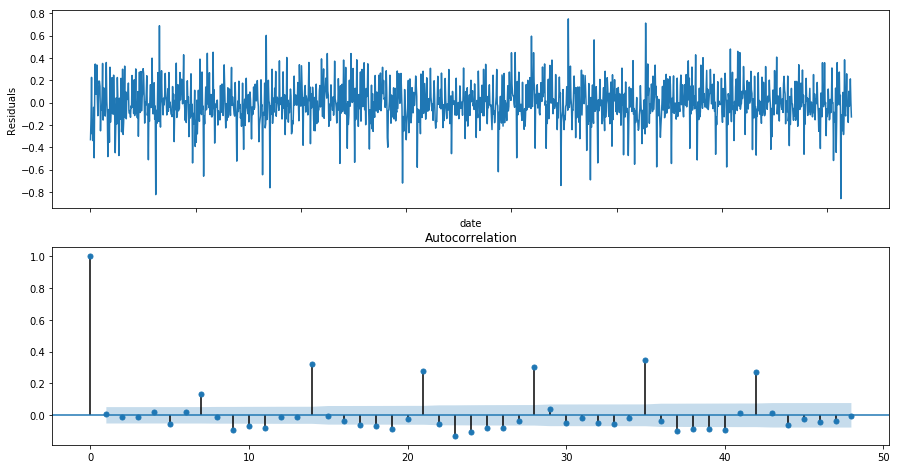

In [53]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [54]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

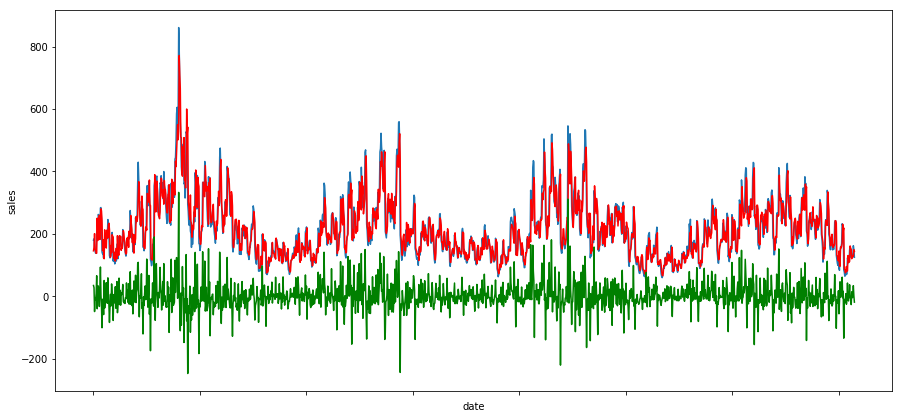

In [55]:
Train['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
Train.sales[30:].plot()
Train.model[30:].plot(color='r')
(Train.sales[30:] - Train.model[30:]).plot(color='g')
plt.ylabel('sales')
plt.show()

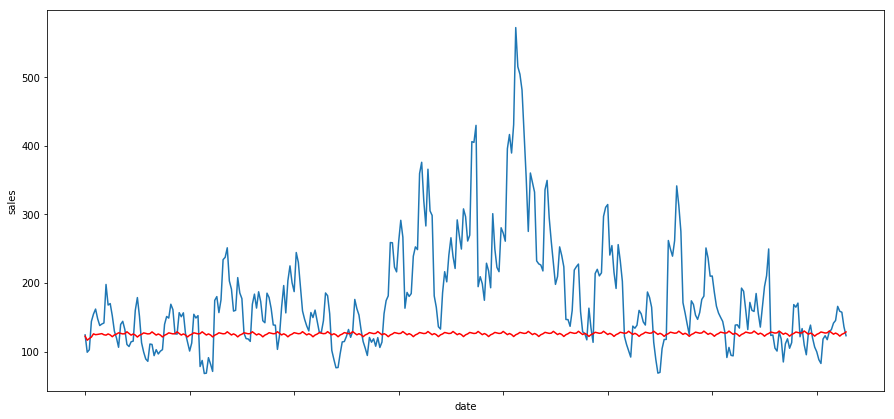

In [56]:
Test['model'] = invboxcox(best_model.predict(start=1461, end=(1461+364)), lmbda)
plt.figure(figsize=(15,7))
Test.sales.plot()
Test.model.plot(color='r')
plt.ylabel('sales')
plt.show()

## Домашнее задание

1. Реализовать метод Prophet для представленных данных. Получить прогноз. Оценить точность.
2. Реализовать метод "Дерево регрессии". Получить прогноз. Оценить точность.
3. Изучить выше представленные методы. Попытаться улучшить прогноз с помощью генерации новых признаков, учета нелинейных зависимостей в признаках, подбора оптимальных гиперпараметров или другими методами.

In [31]:
df.head()

,price,T,sales
date,,,
2014-01-01,126.9,-27,87.110569
2014-01-02,126.9,-25,117.233120
2014-01-03,126.9,-20,109.978085
2014-01-04,126.9,-21,114.134202
2014-01-05,115.9,-24,125.839838


In [24]:
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error

In [25]:
df_fb = pd.DataFrame({'ds': df.index, 'y': df.sales})

#TRAIN/TEST selection
df_fb_train = pd.DataFrame({'ds': Train.index, 'y': Train.sales})
df_fb_test = pd.DataFrame({'ds': Test.index, 'y': Test.sales})

In [61]:
df_fb_test.head()

,ds,y
date,,
2018-01-01,2018-01-01,124.203755
2018-01-02,2018-01-02,98.981338
2018-01-03,2018-01-03,102.576956
2018-01-04,2018-01-04,143.931007
2018-01-05,2018-01-05,154.590535


In [26]:
len(df_fb_test), len(df_fb_train)

(365, 1460)

### FbProphet can work with None value, but outliers can make badly affect on the resulting data 

In [27]:
#Outliers to None function
def outliers_to_na(data, dev):
    median = data['y'].median()
    std = np.std(data['y'])
    for x in range(len(data)):
        val = data['y'][x]
        if (val < median - dev * std or val > median + dev * std):
            data['y'][x] = None
    return data

In [28]:
df_fb_train.isnull().sum()

ds    0
y     0
dtype: int64

In [29]:
df_fb_train.mean(), df_fb_train.median()

(y    214.277503
 dtype: float64, y    195.208933
 dtype: float64)

In [30]:
outliers = float(round(df_fb.mean()*0.01))
df_fb_train = outliers_to_na(df_fb, outliers) 

Don't work with "outliers" function, return NAN result when calculating errors

In [31]:
#Function to the visualize metric
# yhat - y forecast, yhat_lower - lower bound of forecast
# yhat_upper - upper bound of forecast
def quality_control(model, forecast):
    model.plot(forecast)
    model.plot_components(forecast)
    
    cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_fb.set_index('ds'))
    
    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100*cmp_df['e'] / cmp_df['y']
    
    #quality metric
    print('MAE = ', np.round(np.mean(abs (cmp_df[-predictions:]['e'])),2), '%')
    print('Mean absolute deviation: ', np.round(np.mean(abs(cmp_df[-predictions:]['p'])),2))
    return cmp_df

def quality_control_nvis(model, forecast):
    
    cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_fb.set_index('ds'))
    
    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100*cmp_df['e'] / cmp_df['y']
    
    #quality metric
    print('MAE = ', np.round(np.mean(abs (cmp_df[-predictions:]['e'])),2), '%')
    print('Mean absolute deviation: ', np.round(np.mean(abs(cmp_df[-predictions:]['p'])),2))
    

In [36]:
#fit model
prh = Prophet()
prh.fit(df_fb_train)
predictions = 365

#Will forecast future on the 'prediction' dots forward
future = prh.make_future_dataframe(periods = predictions, freq='D')
forecast = prh.predict(future)
pass

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


With daily_seasonality model show results a little worse
*Don't believe what is written on the labels*

MAE =  nan %
Mean absolute deviation:  nan


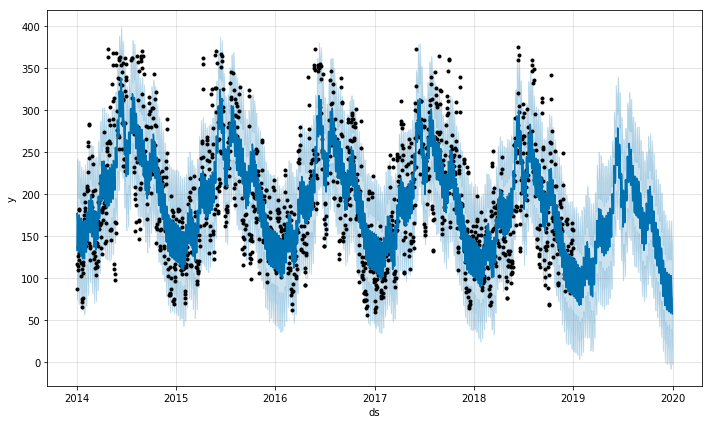

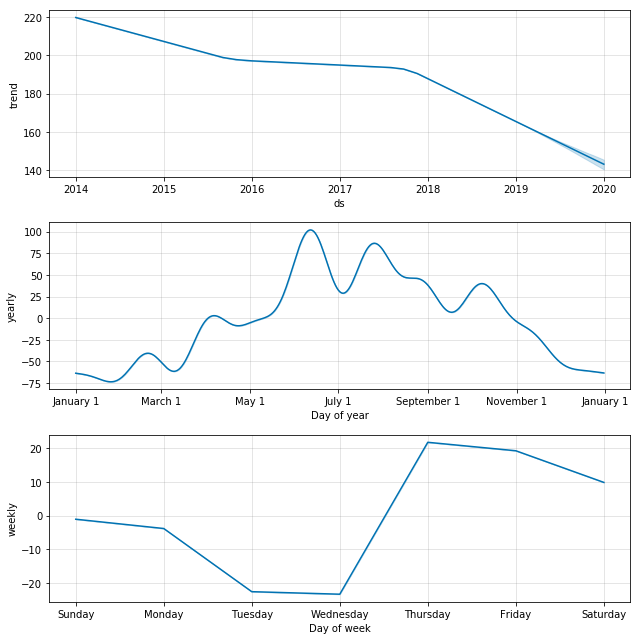

In [37]:
cmp_df = quality_control(prh, forecast)

|№|freq|periods|MAE%|MAD|
|-|---|---|---|---|
|0|H|30|21.94|16.66||
|1|D|7|16.96|13.24| 
|2|D|7|16.86|13.16||
|3|D|30|22.05|15.75|
|4|M|1|21.94|16.66||
|5|M|3|21.71|26.21|
|6|D|90|30.98|22.86||
|7|M|7|42.42|37.12|
|8|D|365|53.38|34.67||
|9|M|30|57.37|43.96|

Number 1 with daily_seasonally=True

In [32]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

In [147]:
def show_forecast(cmp_df, num_predictions, num_values):
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        #marker=dict(color="gray"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        #marker=dict(color="gray"),
        line=dict(width=0),
        mode='lines')

    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # Trace order can be important
    # with continuous error bars
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Sales'),
        title='Prophet sales predictions',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [151]:
show_forecast(cmp_df, predictions, predictions)

Example from the box, doesn't work, i don't know why :c

#### Tuning prophet parameters

In this article(https://dius.com.au/2018/09/04/time-series-forecasting-with-fbprophet/) i saw replacing default sesonality patameter to the custom. Let's try!
Don't foget:
Increase Fourier terms - increase to fit faster changing cycles of seasonality, but it can also to overfitting: N Fourier terms correspond to 2N variables used from modeling cycle.

In [33]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [34]:
model_custom = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
)

model_custom.add_seasonality(
    name='weekly',
    period=7,
    fourier_order=2,
)

model_custom.add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=2,
)
model_custom.fit(df_fb_train)
pass

In [38]:
#Will forecast future on the 'prediction' dots forward
future_custom = model_custom.make_future_dataframe(periods = predictions, freq='D')
forecast_custom = model_custom.predict(future_custom)

In [39]:
cmp_df_custom = quality_control_nvis(model_custom, forecast)

MAE =  nan %
Mean absolute deviation:  nan


It's method doesnt helped us.
Let's try parameter tuning form(https://medium.com/@Psr1/visual-parameter-tuning-with-facebook-prophet-and-python-8f50719c7318)

In [40]:
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 12:00:00 and 2016-12-30 00:00:00
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE =  53.38 %
Mean absolute deviation:  34.67
None


INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 12:00:00 and 2016-12-30 00:00:00
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE =  53.38 %
Mean absolute deviation:  34.67
None


INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 12:00:00 and 2016-12-30 00:00:00
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE =  53.38 %
Mean absolute deviation:  34.67
None


INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 12:00:00 and 2016-12-30 00:00:00
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE =  53.38 %
Mean absolute deviation:  34.67
None


INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 12:00:00 and 2016-12-30 00:00:00
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE =  53.38 %
Mean absolute deviation:  34.67
None


INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 12:00:00 and 2016-12-30 00:00:00
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE =  53.38 %
Mean absolute deviation:  34.67
None


INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 12:00:00 and 2016-12-30 00:00:00


MAE =  53.38 %
Mean absolute deviation:  34.67
None


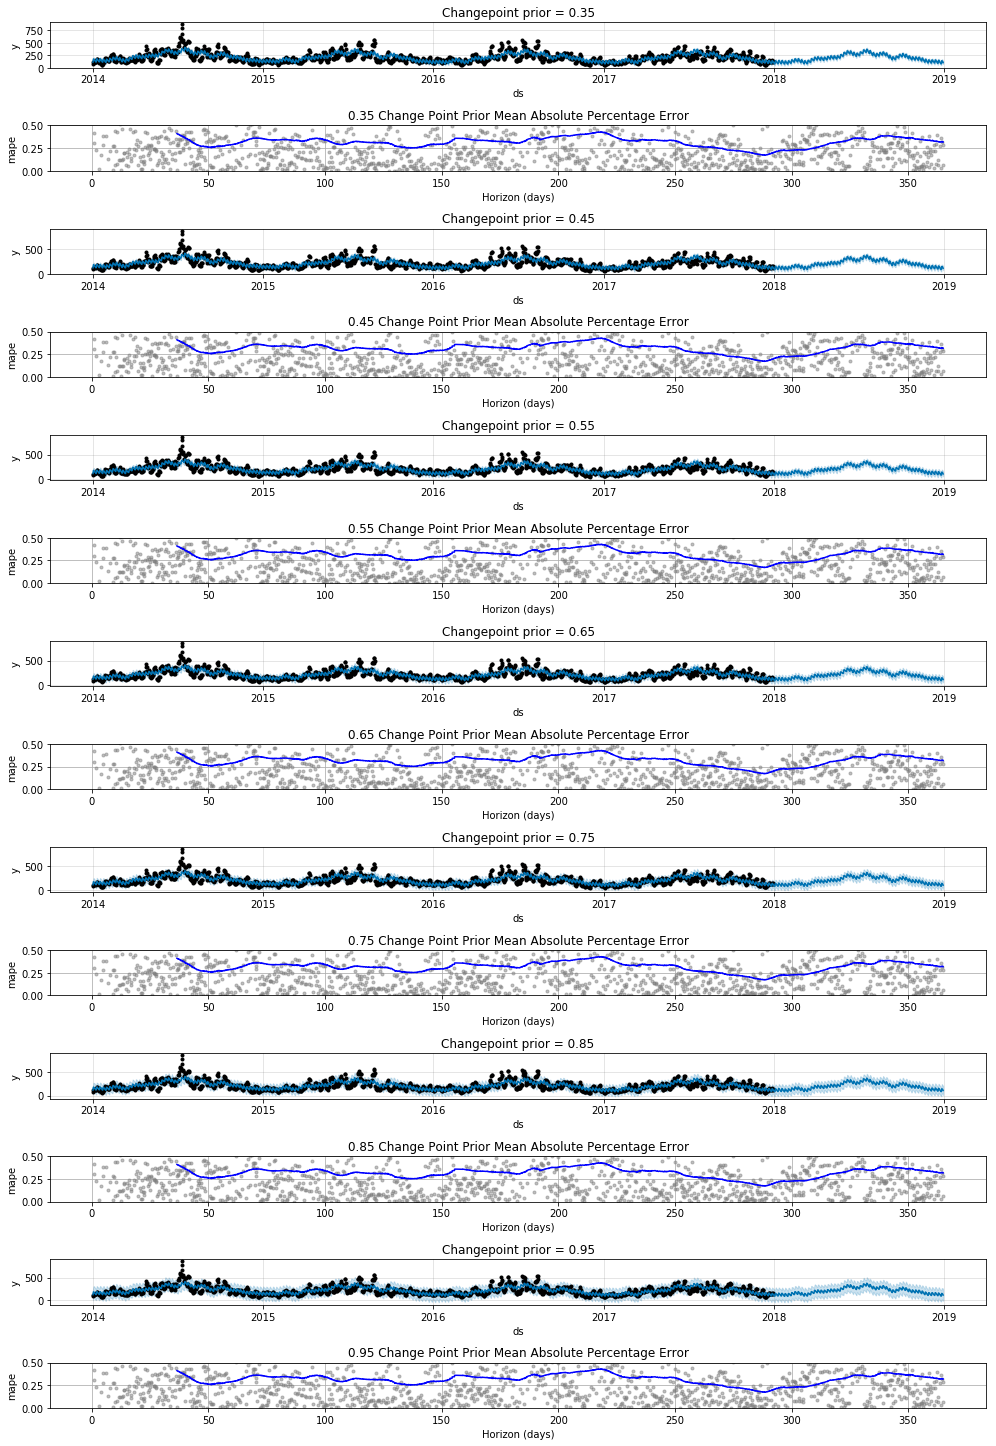

In [213]:
fig, ax = plt.subplots(14,1, figsize = (14,20))
ax = ax.ravel()
j = 0
for i in tqdm([0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]):
    df_fb_train_custom = df_fb_train.copy()
    
    model_custom = Prophet(interval_width = i)
    model_custom.fit(df_fb_train_custom)
    #make dataframe to next year
    future_custom = model_custom.make_future_dataframe(periods = predictions, freq='D')
    forecast_custom = model_custom.predict(future_custom)
    
    #plot the forecast
    fig =model_custom.plot(forecast_custom, ax = ax[j])
    ax[j].set_title("Changepoint prior = "+str(i))
    j+=1
    
    df_cv_custom = cross_validation(model_custom,initial = '365 days', horizon = str(predictions)+' days')
    df_p_custom = performance_metrics(df_cv_custom)
    fig = plot_cross_validation_metric(df_cv_custom, metric="mape", ax = ax[j])
    
    ax[j].set_title(str(i) + ' Change Point Prior Mean Absolute Percentage Error')
    ax[j].set_ylim(0,0.5)
    j+=1

It's easy to see visually that varying the interval_width doesn't make a big effect on the accuracy of the model.

## Random forest

In [130]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train_all, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [131]:
Pred_rf_train = rf.predict(X_train_all)
Pred_rf_test = rf.predict(X_test_all)

print('MAD in train: ', np.round(mean_absolute_error(Y_train, Pred_rf_train), 2))
print('MAD in test: ', np.round(mean_absolute_error(Y_test, Pred_rf_test), 2))

MAD in train:  9.76
MAD in test:  30.87


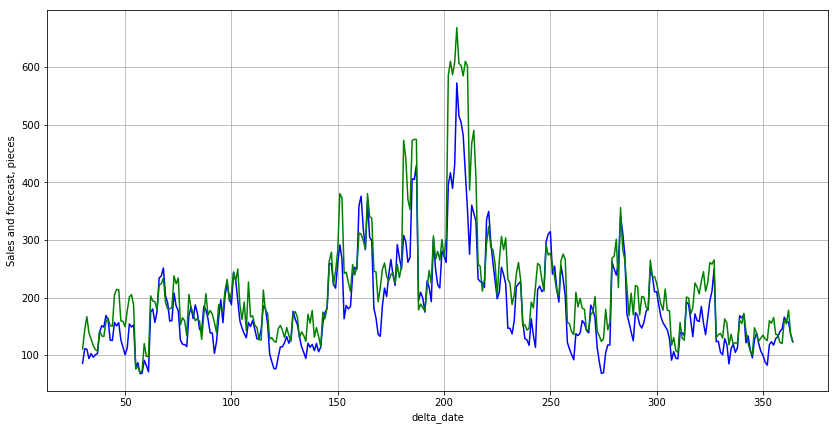

In [43]:
plt.figure(figsize=(14,7))
x=range(len(Y_test))
plt.plot(x[30:], Y_test[30:], 'b')
plt.plot(x[30:], Pred_rf_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Sales and forecast, pieces')
plt.grid()
pass

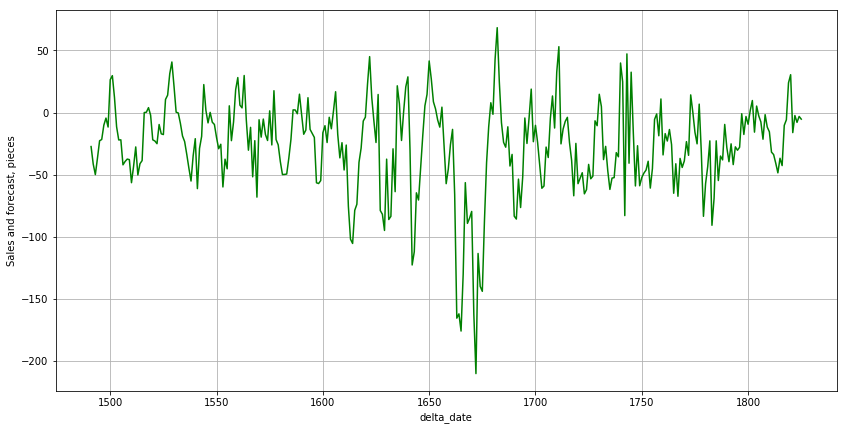

In [143]:
plt.figure(figsize=(14,7))
plt.plot(Y_test[30:] - Pred_rf_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Sales and forecast, pieces')
plt.grid()
pass

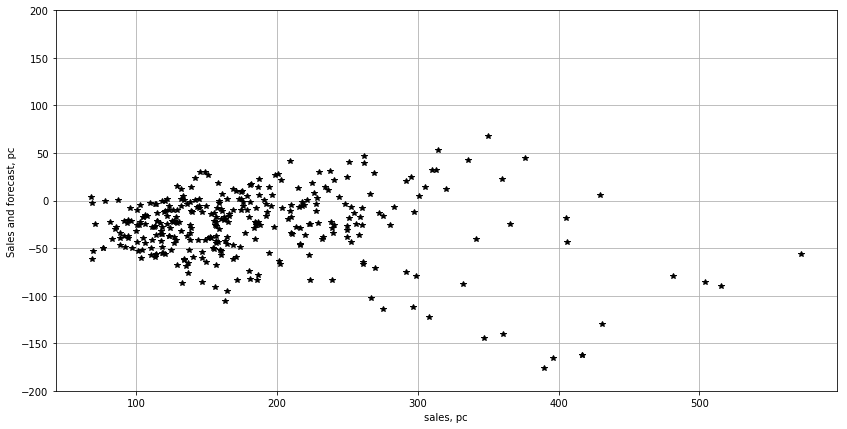

In [144]:
plt.figure(figsize=(14,7))
plt.plot(Y_test[30:], Y_test[30:] - Pred_rf_test[30:], 'k*')
plt.ylim([-200, 200])
plt.xlabel('sales, pc')
plt.ylabel('Sales and forecast, pc')
plt.grid()
pass

|Method|Train|Test|
|---|---|---|
|LinReg|28.18|24.94||
|Ridge|28.33|24.65|
|Lasso|28.25|24.73||
|ElNet|29.08|23.7|
|FutElNet|22.65|22.0||
|RanFor|9.98|33.38|


#### Future importance

Apply the experience if this(https://explained.ai/rf-importance/)  lecturer on our sample. And create permutation importance function:

In [104]:
from sklearn.metrics import r2_score

def r2(rf, X_train, Y_train):
    return r2_score(Y_train, rf.predict(X_train))

def permutation_importances(rf, X_train, Y_train, metric):
    baseline = metric(rf, X_train, Y_train)
    imp = []
    for col in tqdm(pd.DataFrame(X_train).columns):
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, Y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)    

In [162]:
def feature_imp(rf, X_train_all, X_test_all):
    feature_importances = pd.DataFrame(rf.feature_importances_,
                                     index = pd.DataFrame(X_train_all).columns,
                                     columns = ['importance']).sort_values(
                                    'importance', ascending=False)
    
    Pred_rf_train = rf.predict(X_train_all)
    Pred_rf_test = rf.predict(X_test_all)

    feature_importances.plot(kind = 'bar', title = " MAD in train: " + \
                            str(np.round(mean_absolute_error(Y_train, Pred_rf_train), 2)) + \
                            " \nMAD in test: " + str(np.round(mean_absolute_error(Y_test, Pred_rf_test), 2)),
                           grid=True)
    

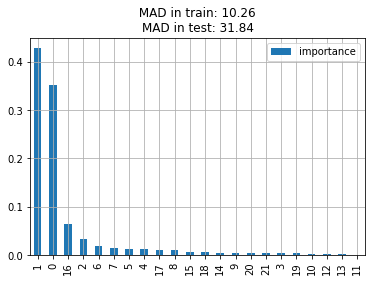

In [163]:
feature_imp(rf, X_train_all,X_test_all)

Use importance permutation

In [133]:
rf = RandomForestRegressor()
rf.fit(X_train_all, Y_train)
imp = permutation_importances(rf, X_train_all, Y_train, r2)
pass

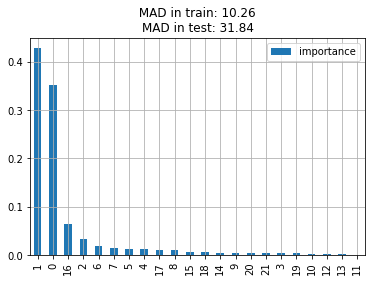

In [134]:
feature_imp(rf, X_train_all, X_test_all)

MAE and MAD doesn't change on big value - it's mean our model has better statistical properties.

### Future selection

In [135]:
from sklearn.feature_selection import SelectFromModel

In [171]:
sel = SelectFromModel(RandomForestRegressor(
                      n_estimators=100,
                      min_samples_leaf=1,
                      n_jobs=-1,
                      oob_score=True))
sel.fit(X_train_all, Y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [174]:
sel.get_support(indices=True)

array([ 0,  1, 16])

In [175]:
X_train_imp = sel.transform(X_train_all)
X_test_imp = sel.transform(X_test_all)

In [177]:
sel_imp = RandomForestRegressor(
                      n_estimators=100,
                      min_samples_leaf=1,
                      n_jobs=-1,
                      oob_score=True)
sel_imp.fit(X_train_imp, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

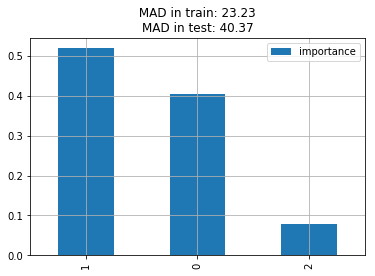

In [178]:
feature_imp(sel_imp, X_train_imp, X_test_imp)

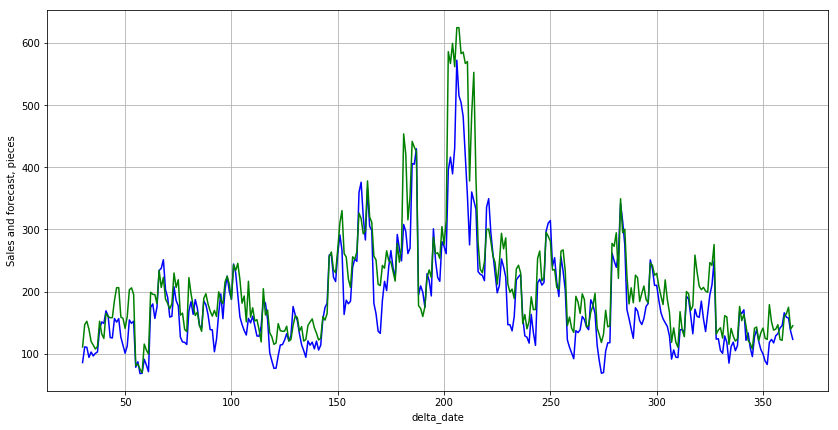

In [180]:
plt.figure(figsize=(14,7))
x=range(len(Y_test))
plt.plot(x[30:], Y_test[30:], 'b')
plt.plot(x[30:], Pred_rf_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Sales and forecast, pieces')
plt.grid()
pass

Oh, this bad, but we try)

### Let's try use RandomizedSearchCV

In [181]:
from sklearn.model_selection import RandomizedSearchCV

In [183]:
#Tree count
n_estimators = [int(tree) for tree in np.linspace(start =1, stop = 1000, num= 50)]
#features count
max_features = ['auto', 'sqrt']
#max deep
max_depth = [int(x) for x in np.linspace(10,110, num = 11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]

bootstrap= [True, False]

random_grid = {
                'n_estimators' : n_estimators,
                'max_features' : max_features,
                'max_depth' : max_depth,
                'min_samples_split' : min_samples_split,
                'bootstrap' : bootstrap
}

In [186]:
rf_rand = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf_rand, param_distributions = random_grid, n_iter = 100,
                              cv = 3, verbose = 2, random_state = 42, n_jobs = -1)
rf_random.fit(X_train_all, Y_train)
pass

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished
/home/lucius/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [185]:
Pred_rf_train = rf_random.predict(X_train_all)
Pred_rf_test = rf_random.predict(X_test_all)

print('MAD in train: ', np.round(mean_absolute_error(Y_train, Pred_rf_train), 2))
print('MAD in test: ', np.round(mean_absolute_error(Y_test, Pred_rf_test), 2))
print(rf_random.best_params_)

MAD in train:  0.73
MAD in test:  29.98
{'n_estimators': 429, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


In [187]:
#Place for the final graphics maded on plotly, but i didn'thave time to do it :)) 

From the box Prophet have nice results, but i couldn't make it better. In other alghorithms better by L1+L2 ElasticNet, maybe it was reasonable to adjust it for the best result. 
But i have a problem here, tqdm doesn't work... Again, now in Prophet parameter brute, plotly doesn't want to draw f beautiful graphics for me and I recieved "NAN" in work code part(i get it on ITIS). It's strange, but for this we are all here today)